In [1]:
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = [os.path.join(PATH, "images/ds1"), os.path.join(PATH, "images/ds1/albumentated")]

images = []
labels = []

for si in SOURCE_IMAGES:
    images.extend(glob(os.path.join(si, "*.jpg")))
    labels.extend(glob(os.path.join(si.replace("images","labels"), "*.png")))

In [3]:
images.sort()
labels.sort()

In [4]:
print(np.size(images))
print(np.size(labels))

143
143


In [6]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)
    
del(images, labels, full_size_image, full_size_label)

In [7]:
x = np.asarray(x[:10])
y = np.asarray(y[:10])

In [8]:
print(y.min())
print(y.max())
print(x.shape)
print(y.shape)

0
8
(10, 1024, 1280, 3)
(10, 1024, 1280)


In [9]:
# Crop squared image
n_images, h, w = x.shape[0:3]

x = x[:,:,(w-h)//2:(w-(w-h)//2),:]
y = y[:,:,(w-h)//2:(w-(w-h)//2)]

n_images, h, w = x.shape[0:3]

print(x.shape)
print(y.shape)

(10, 1024, 1024, 3)
(10, 1024, 1024)


In [10]:
h_t, w_t = (512,512)
split_factor = 4 # We crop this number of smaller images out of one
x_t = np.zeros([n_images*split_factor, h_t, w_t, 3], dtype='uint8')
y_t = np.zeros([n_images*split_factor, h_t, w_t], dtype='uint8')

for i in range(n_images):
    x_t[i] = x[i,:h//2,:w//2,:]
    x_t[n_images+i] = x[i,:h//2,w//2:w,:]
    x_t[n_images*2+i] = x[i,h//2:h,:w//2,:]
    x_t[n_images*3+i] = x[i,h//2:h,w//2:w,:]
    y_t[i] = y[i,:h//2,:w//2]
    y_t[n_images+i] = y[i,:h//2,w//2:w]
    y_t[n_images*2+i] = y[i,h//2:h,:w//2]
    y_t[n_images*3+i] = y[i,h//2:h,w//2:w]
    
x = x_t
y = y_t
del(x_t,y_t)

In [11]:
cs = ['background', 'asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']

In [16]:
n_classes = len(cs)

from keras.utils import to_categorical

y = to_categorical(y, num_classes=n_classes)
y = y.reshape(x.shape[:3] + (n_classes,))
y.shape

(40, 512, 512, 9)

In [13]:
x = x/255

In [27]:
from models.Unet import unet
from keras import optimizers

model = unet(input_size = x.shape[1:], n_classes=n_classes)
model.load_weights('weights/some_name.hdf5')
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [35]:
# a = model.evaluate(x=x[:2], y=y[:2], batch_size=1, verbose=1)

In [36]:
y_pred = model.predict(x[:2], batch_size=1, verbose=1)

2/2 [==============================] - 1s     


In [38]:
import webcolors

hex_colors = ['#000000','#4A4A4A','#FF0000', '#407700', '#00FF37', '#8B572A', '#0000FF', '#FF7600', '#50E3C2']

rgb_colors = []

for hex_color in hex_colors:
    rgb_colors.append(webcolors.hex_to_rgb(hex_color))
    
def colorize(mask, colors):
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

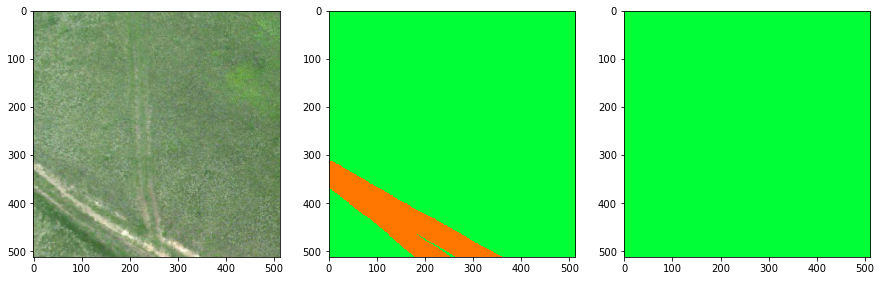

In [59]:
n = 1

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15,5)
axes[0].imshow(x[n])
axes[1].imshow(colorize(np.argmax(y[n],axis=-1), colors = np.array(rgb_colors)))
axes[2].imshow(colorize(np.argmax(y_pred[n],axis=-1), colors = np.array(rgb_colors)))